# Late Fusion
## Modality 1: House characteristics

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

### Paths

In [2]:
input_path = '../../../2_data_preprocessing/output/'

output_path = '../output/'

# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load and shuffle data

In [4]:
train_df = pd.read_csv(os.path.join(input_path, 'train_m1_encoded_df.csv'))

In [5]:
train_df

,hired_aid,has_TV,has_paid_TV,has_radio,has_audio_system,has_computer,has_cell_phone,has_internet,has_phone,has_iron,...,strata_3rd_strata,strata_4th_strata,locality_type_rural,locality_type_urban,"locality_size_15,000-99,999","locality_size_2,500-14,999","locality_size_<2,500","locality_size_>100,000",label,group
0,0,1,0,1,1,0,1,1,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,3
1,0,1,1,1,0,0,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,3
2,0,1,1,1,1,1,1,1,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,4
3,0,1,0,0,0,1,1,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3
4,0,1,1,1,1,0,1,0,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9580,0,1,1,0,0,0,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,5
9581,0,1,1,0,0,0,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,3
9582,0,1,1,1,0,1,1,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,3
9583,0,1,1,1,0,1,1,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,4


In [6]:
from sklearn.utils import shuffle

train_shuffled_df = shuffle(train_df, random_state=seed).reset_index(drop=True)

In [7]:
train_shuffled_df

,hired_aid,has_TV,has_paid_TV,has_radio,has_audio_system,has_computer,has_cell_phone,has_internet,has_phone,has_iron,...,strata_3rd_strata,strata_4th_strata,locality_type_rural,locality_type_urban,"locality_size_15,000-99,999","locality_size_2,500-14,999","locality_size_<2,500","locality_size_>100,000",label,group
0,0,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3
1,0,0,0,0,0,0,1,0,1,0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,5
2,0,1,1,0,1,0,1,0,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3
3,0,1,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,5
4,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9580,0,1,0,0,1,0,1,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,4
9581,0,1,1,1,1,0,1,1,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,4
9582,0,1,1,1,1,1,1,1,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3
9583,0,1,1,1,1,0,1,0,0,0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,5


## Other functions

In [8]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([2,2])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(label_id_to_label_num.keys()), list(label_id_to_label_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')

## Elastic Net SGD Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_m1.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m1.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_m1.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
SGDClassifier(alpha=0.0025, class_weight='balanced', l1_ratio=0.3, loss='log',
              max_iter=2500, n_iter_no_change=20, penalty='elasticnet',
              random_state=27)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
500,0.576303,0.399610,0.043199,0.076900,0.0025,balanced,0.3,log,2500,20,...,27,"{'alpha': 0.0025, 'class_weight': 'balanced', ...",0.564640,0.546816,0.580232,0.564031,0.554877,0.562119,0.011178,1
496,0.454521,0.390821,0.043600,0.077701,0.0025,balanced,0.25,log,2500,20,...,27,"{'alpha': 0.0025, 'class_weight': 'balanced', ...",0.564032,0.546630,0.580012,0.563183,0.556095,0.561990,0.010964,2
492,1.079659,0.161643,0.044000,0.078000,0.0025,balanced,0.2,log,2500,20,...,27,"{'alpha': 0.0025, 'class_weight': 'balanced', ...",0.564760,0.546262,0.578814,0.563829,0.556214,0.561976,0.010722,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


AUC_avg (train): 0.5707194256903916
AUC_std (train): 0.0029671429554149983
AUC_avg (validation): 0.562119035560915
AUC_std (validation): 0.011177810615159368


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


UAR_avg (train): 0.5504847329600068
UAR_std (train): 0.0064444609502474215
UAR_avg (validation): 0.5435867989810642
UAR_std (validation): 0.006853401603332075


C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


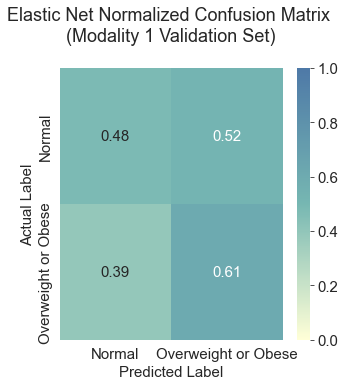

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m1.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Elastic Net Normalized Confusion Matrix 
(Modality 1 Validation Set)
""",
                      file_name = 'conf_mat_elastic_net_m1.svg',
                      report    = True 
                     )

## kNN Classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_m1.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_m1.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_m1.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits
KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='manhattan',
                     n_jobs=-1, n_neighbors=566)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
294,0.283399,0.119175,4.349149,0.177261,ball_tree,20,manhattan,-1,566,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 20, 'm...",0.568323,0.550738,0.571223,0.557415,0.561084,0.561757,0.007395,1
474,0.333019,0.071847,3.825803,0.368549,ball_tree,30,manhattan,-1,561,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.567788,0.553549,0.569288,0.555426,0.561344,0.561479,0.006330,2
114,0.624839,0.111404,5.275058,0.311122,ball_tree,10,manhattan,-1,571,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",0.565853,0.552350,0.569082,0.556700,0.563222,0.561441,0.006102,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


AUC_avg (train): 0.5701774146804257
AUC_std (train): 0.00261396641344481
AUC_avg (validation): 0.5617565825336925
AUC_std (validation): 0.007395371885228347


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


UAR_avg (train): 0.5039204820231813
UAR_std (train): 0.001489734156631358
UAR_avg (validation): 0.5020129326422342
UAR_std (validation): 0.001722043741978535


C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature name

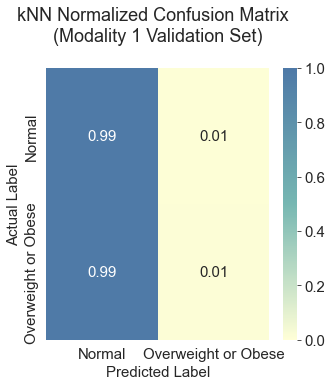

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_m1.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """kNN Normalized Confusion Matrix  
(Modality 1 Validation Set)
""",
                      file_name = 'conf_mat_knn_m1.svg'
                     )

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_m1.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_m1.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_m1.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=13,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       random_state=27, splitter='random')


In [16]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1762,0.104405,0.081981,0.011400,0.008261,random,27,0.2,0.1,13,40,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.555315,0.550546,0.556269,0.566009,0.557914,0.55721,0.005036,1
669,0.165200,0.122408,0.004799,0.000400,random,27,0.2,0.1,13,10,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.555315,0.550546,0.556269,0.566009,0.557914,0.55721,0.005036,1
2059,0.068000,0.100045,0.059200,0.096441,random,27,0.1,0.1,13,50,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.555315,0.550546,0.556269,0.566009,0.557914,0.55721,0.005036,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.5601330401340123
AUC_std (train): 0.0010009588940758205
AUC_avg (validation): 0.5572104539609881
AUC_std (validation): 0.005036143370061922


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


UAR_avg (train): 0.546609982590653
UAR_std (train): 0.0014307553930074683
UAR_avg (validation): 0.5484261394833394
UAR_std (validation): 0.006336375822166766


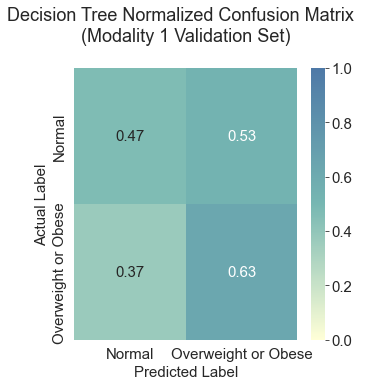

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_m1.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Decision Tree Normalized Confusion Matrix  
(Modality 1 Validation Set)
""",
                      file_name = 'conf_mat_tree_m1.svg'
                     )

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_m1.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_m1.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_m1.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=108, n_jobs=-1, random_state=27)


In [19]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4605,4.254000,1.457512,5.339812,0.772779,27,-1,108,5,2,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.572888,0.548145,0.543635,0.558722,0.557962,0.556271,0.010106,1
476,4.892942,0.267665,8.351735,0.332262,27,-1,188,5,2,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.570955,0.548867,0.545354,0.557448,0.557013,0.555927,0.008843,2
3314,7.097409,3.549815,3.610987,1.283771,27,-1,183,2,1,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.569740,0.548795,0.546419,0.557241,0.557372,0.555913,0.008196,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.7398778496410694
AUC_std (train): 0.0024392764602056785
AUC_avg (validation): 0.5562705660416871
AUC_std (validation): 0.010106459444684105


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


UAR_avg (train): 0.6643972170592498
UAR_std (train): 0.002527692165639328
UAR_avg (validation): 0.5437052371846254
UAR_std (validation): 0.008078747356424432


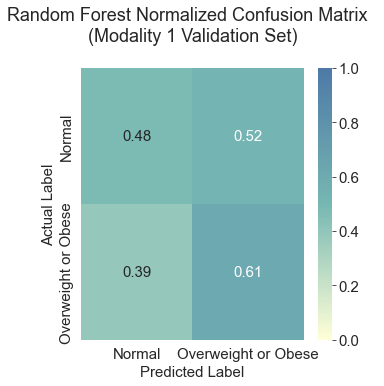

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_m1.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix  
(Modality 1 Validation Set)
""",
                      file_name = 'conf_mat_rf_m1.svg'
                     )